In [ ]:
from tensorflow import keras
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import logging
import os
import warnings

import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

from datetime import datetime
from keras.preprocessing import image
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from tensorflow.keras import layers

# from utils import *

warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.ERROR)


print("TF version:", tf.__version__)

TF version: 2.8.0


# Create Data Pipeline

In [ ]:
!unzip /content/drive/MyDrive/ARVhackathon/Data/Dataset.zip -d /content/house-grade/

Streaming output truncated to the last 5000 lines.
  inflating: /content/house-grade/Dataset/train/img_13-8009109_100-5673471_a103-9340052_s193-9340052_y0_f90_1-aug(1, 1).jpg  
  inflating: /content/house-grade/Dataset/train/img_13-800913_100-5876526_a83-2692183673582_s173-2692183673582_y0_f90_1.jpg  
  inflating: /content/house-grade/Dataset/train/img_13-800913_100-5876526_a83-2692183673582_s173-2692183673582_y0_f90_1-aug(0, 0).jpg  
  inflating: /content/house-grade/Dataset/train/img_13-800913_100-5876526_a83-2692183673582_s173-2692183673582_y0_f90_1-aug(1, 1).jpg  
  inflating: /content/house-grade/Dataset/train/img_13-800913_100-5876526_a83-2692183673582_s353-26921836735823_y0_f90_1.jpg  
  inflating: /content/house-grade/Dataset/train/img_13-800913_100-5876526_a83-2692183673582_s353-26921836735823_y0_f90_1-aug(0, 0).jpg  
  inflating: /content/house-grade/Dataset/train/img_13-800913_100-5876526_a83-2692183673582_s353-26921836735823_y0_f90_1-aug(1, 1).jpg  
  inflating: /content/ho

In [ ]:
import pandas as pd
metadata = pd.read_csv('/content/house-grade/Dataset/train.csv')

In [ ]:
metadata.head()

,image_name,class
0,ChokChai4_img_13-7956791_100-6031267_a187-2159...,0
1,ChokChai4_img_13-7961753_100-6031881_a185-9785...,0
2,ChokChai4_img_13-7969811_100-5906061_a180-5812...,0
3,ChokChai4_img_13-7970811_100-5906071_a180-5812...,0
4,ChokChai4_img_13-7971811_100-5906081_a180-5812...,0


In [ ]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9814 entries, 0 to 9813
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  9814 non-null   object
 1   class       9814 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 153.5+ KB


In [ ]:
train_id = []
train_full_path = []
train_path = "/content/house-grade/Dataset/train"
for im in os.listdir(train_path):
  train_id.append(im)
  train_full_path.append(train_path + '/' + im)

In [ ]:
path_meta = pd.DataFrame(columns=["image_name", "path"])
path_meta["image_name"] = train_id
path_meta["path"] = train_full_path

In [ ]:
metadata = pd.merge(metadata, path_meta, on="image_name", how="left")

In [ ]:
metadata.head()

,image_name,class,path
0,ChokChai4_img_13-7956791_100-6031267_a187-2159...,0,/content/house-grade/Dataset/train/ChokChai4_i...
1,ChokChai4_img_13-7961753_100-6031881_a185-9785...,0,/content/house-grade/Dataset/train/ChokChai4_i...
2,ChokChai4_img_13-7969811_100-5906061_a180-5812...,0,/content/house-grade/Dataset/train/ChokChai4_i...
3,ChokChai4_img_13-7970811_100-5906071_a180-5812...,0,/content/house-grade/Dataset/train/ChokChai4_i...
4,ChokChai4_img_13-7971811_100-5906081_a180-5812...,0,/content/house-grade/Dataset/train/ChokChai4_i...


# Split Dataset

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(metadata['path'], metadata['class'], test_size=0.1, random_state=44)
print("Number of posters for training: ", len(X_train))
print("Number of posters for validation: ", len(X_val))

Number of posters for training:  8832
Number of posters for validation:  982


In [ ]:
# Print example of movie posters and their  targets
for i in range(3):
    print(X_train[i], y_train[i])

/content/house-grade/Dataset/train/ChokChai4_img_13-7956791_100-6031267_a187-21598902886774_s90_y0_f90_1.jpg 0
/content/house-grade/Dataset/train/ChokChai4_img_13-7961753_100-6031881_a185-978546002526_s90_y0_f90_1.jpg 0
/content/house-grade/Dataset/train/ChokChai4_img_13-7969811_100-5906061_a180-5812875399312_s270_y0_f90_1.jpg 0


# Input Pipeline

In [ ]:
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model

BATCH_SIZE = 32 # Big enough to measure an F1-score
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunk of 1024 observations

# Other constants
MEAN = tf.constant([0.485 * 255, 0.456 * 255, 0.406 * 255])  # imagenet mean
STD = tf.constant([0.229 * 255, 0.224 * 255, 0.225 * 255])  # imagenet std
AUTO = tf.data.AUTOTUNE

# Feature Extractor
MODEL_PATH = "https://tfhub.dev/sayakpaul/convnext_xlarge_21k_1k_224_fe/1"

def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    #image_normalized = (image - MEAN) / STD
    image_normalized = image_resized / 255.0
    return image_normalized, label

def parse_function_predict(filename):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    #image_normalized = (image - MEAN) / STD
    image_normalized = image_resized / 255.0
    return image_normalized


def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

def create_predict_dataset(filenames):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function_predict, num_parallel_calls=AUTOTUNE)
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)

    
    return dataset


In [ ]:
# Create Dataset

train_ds = create_dataset(X_train, y_train)
val_ds = create_dataset(X_val, y_val)

In [ ]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (32, 224, 224, 3)
Shape of labels array: (32,)


# LR Scheduler Utility

In [ ]:
class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        learning_rate = (
            0.5
            * self.learning_rate_base
            * (
                1
                + tf.cos(
                    self.pi
                    * (tf.cast(step, tf.float32) - self.warmup_steps)
                    / float(self.total_steps - self.warmup_steps)
                )
            )
        )

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

# Model


In [ ]:
def get_model(model_path=MODEL_PATH, res=224, num_classes=6):
    hub_layer = hub.KerasLayer(model_path, trainable=False)
    print()

    model = keras.Sequential(
        [
            keras.layers.InputLayer((res, res, 3)),
            hub_layer,
            tf.keras.layers.Dense(1024, activation = 'relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1024, activation = 'relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(num_classes, activation="softmax"),
        ]
    )
    return model

In [ ]:
get_model().summary(expand_nested=True)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              348147968 
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                       

# Training Hyperparameter

In [ ]:
EPOCHS = 40
WARMUP_STEPS = 5
INIT_LR = 1e-3
WAMRUP_LR = 1e-3
num_train = 8832
num_val = 982

TOTAL_STEPS = int((num_train / BATCH_SIZE) * EPOCHS)

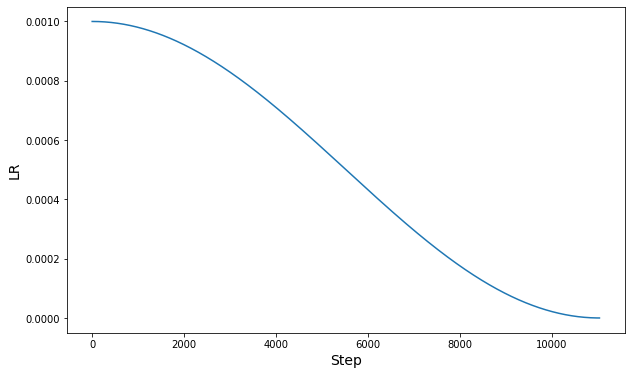

In [ ]:
scheduled_lrs = WarmUpCosine(
    learning_rate_base=INIT_LR,
    total_steps=TOTAL_STEPS,
    warmup_learning_rate=WAMRUP_LR,
    warmup_steps=WARMUP_STEPS,
)

lrs = [scheduled_lrs(step) for step in range(TOTAL_STEPS)]
plt.figure(figsize=(10, 6))
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()


In [ ]:
optimizer = keras.optimizers.Adam(scheduled_lrs)
#optimizer = keras.optimizers.Adam(scheduled_lrs)
loss = keras.losses.SparseCategoricalCrossentropy()

In [ ]:
from tensorflow.keras.callbacks import Callback , EarlyStopping , ModelCheckpoint , ReduceLROnPlateau

checkpoint = ModelCheckpoint( filepath = '/content/drive/MyDrive/ARVhackathon/model/ConvnetXLTestfinetune/', monitor='val_loss', verbose=0, save_best_only=True,
                            save_weights_only=True, mode='auto', save_freq='epoch')
earlystop =  EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0,
                            mode='auto', baseline=None, restore_best_weights=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')

callbacks = [checkpoint]

In [ ]:
@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

# Training Model

In [ ]:
model = get_model(MODEL_PATH)

In [ ]:
model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])

In [ ]:
history = model.fit(x=train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS,
                    callbacks=callbacks)

Epoch 1/40
276/276 [==============================] - 278s 1s/step - loss: 0.0170 - accuracy: 0.9941 - val_loss: 0.4762 - val_accuracy: 0.8941
Epoch 2/40
276/276 [==============================] - 278s 1s/step - loss: 0.0142 - accuracy: 0.9956 - val_loss: 0.4881 - val_accuracy: 0.8910
Epoch 3/40
 15/276 [>.............................] - ETA: 3:56 - loss: 0.0168 - accuracy: 0.9937

KeyboardInterrupt: ignored

# Prediction

In [ ]:
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model

BATCH_SIZE = 16 # Big enough to measure an F1-score
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunk of 1024 observations

# Other constants
MEAN = tf.constant([0.485 * 255, 0.456 * 255, 0.406 * 255])  # imagenet mean
STD = tf.constant([0.229 * 255, 0.224 * 255, 0.225 * 255])  # imagenet std
AUTO = tf.data.AUTOTUNE

# Feature Extractor
MODEL_PATH = "https://tfhub.dev/sayakpaul/convnext_xlarge_21k_1k_224_fe/1"

def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    #image_normalized = (image - MEAN) / STD
    image_normalized = image_resized / 255.0
    return image_normalized, label

def parse_function_predict(filename):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    #image_normalized = (image - MEAN) / STD
    image_normalized = image_resized / 255.0
    return image_normalized


def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

def create_predict_dataset(filenames):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function_predict, num_parallel_calls=AUTOTUNE)
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)

    
    return dataset


In [ ]:
def get_model(model_path=MODEL_PATH, res=224, num_classes=6):
    hub_layer = hub.KerasLayer(model_path, trainable=False)
    print()

    model = keras.Sequential(
        [
            keras.layers.InputLayer((res, res, 3)),
            hub_layer,
            keras.layers.Dense(1024, activation="relu"),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(1024, activation="relu"),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(num_classes, activation="softmax"),
        ]
    )
    return model

In [ ]:
model = get_model(MODEL_PATH)

In [ ]:
model.load_weights('/content/drive/MyDrive/ARVhackathon/model/ConvnetXLNewfinetune/')

In [ ]:
import pandas as pd

In [ ]:
!unzip /content/drive/MyDrive/ARVhackathon/Data/final_test.zip -d /content/test/

Archive:  /content/drive/MyDrive/ARVhackathon/Data/final_test.zip
  inflating: /content/test/final_test/00162f19.jpg  
  inflating: /content/test/final_test/004c4789.jpg  
  inflating: /content/test/final_test/0059b42f.jpg  
  inflating: /content/test/final_test/005f930c.jpg  
  inflating: /content/test/final_test/009095e8.jpg  
  inflating: /content/test/final_test/00a98706.jpg  
  inflating: /content/test/final_test/00da9dd7.jpg  
  inflating: /content/test/final_test/00e2bfe0.jpg  
  inflating: /content/test/final_test/00eac2a3.jpg  
  inflating: /content/test/final_test/01265567.jpg  
  inflating: /content/test/final_test/0188f57d.jpg  
  inflating: /content/test/final_test/01945b53.jpg  
  inflating: /content/test/final_test/01ccbb76.jpg  
  inflating: /content/test/final_test/01e45f69.jpg  
  inflating: /content/test/final_test/01ee5917.jpg  
  inflating: /content/test/final_test/01f9d203.jpg  
  inflating: /content/test/final_test/0264a981.jpg  
  inflating: /content/test/final_

In [ ]:
test_df = pd.read_csv('/content/sample_submission.csv')

In [ ]:
#test_df['Id'] = test_df['Id'] + '.jpg'

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1550 entries, 0 to 1549
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         1550 non-null   object 
 1   Predicted  3 non-null      float64
dtypes: float64(1), object(1)
memory usage: 24.3+ KB


In [ ]:
test_path = '/content/test/final_test/'
#test_sameple_list = test_df['Id'].tolist()
test_sameple_list = os.listdir('/content/test/final_test/')
test_full_path = [test_path+img for img in test_sameple_list]

In [ ]:
len(test_full_path)

1550

In [ ]:
predict_ds = create_predict_dataset(test_full_path)

In [ ]:
for f in predict_ds.take(1):
    print("Shape of features array:", f.numpy().shape)

Shape of features array: (16, 224, 224, 3)


In [ ]:
pred = model.predict(predict_ds)

In [ ]:
pred = list(pred)
#test_sameple_list = id
id = [imgpath.split('.')[0] for imgpath in test_sameple_list]

In [ ]:
predict = []
import numpy as np
for i , val in enumerate(pred):
  predict.append(np.argmax(pred[i]))

In [ ]:
predictions = pd.DataFrame(columns=["Id", "Predicted"])
predictions["Id"] = id
predictions["Predicted"] = predict

In [ ]:
sample_submission = pd.read_csv("/content/sample_submission.csv")

In [ ]:
final_result_df = pd.merge(sample_submission, predictions, on="Id", how="left")

In [ ]:
final_result_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1550 entries, 0 to 1549
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Id           1550 non-null   object 
 1   Predicted_x  3 non-null      float64
 2   Predicted_y  1550 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 48.4+ KB


In [ ]:
final_result_df = final_result_df.rename(columns={"Predicted_y": "Predicted"})

In [ ]:
final_result_df = final_result_df.drop(['Predicted_x'], axis = 1)

In [ ]:
final_result_df['Predicted'] = final_result_df['Predicted'].fillna(0)

In [ ]:
final_result_df['Predicted'] = final_result_df['Predicted'].astype(int)

In [ ]:
final_result_df.head()

,Id,Predicted
0,9b8b6867,0
1,165a6b47,5
2,9db2bde8,4
3,46c1f278,0
4,a956fc6f,0


In [ ]:
final_result_df.to_csv("Convnext_trainfromscratch.csv", index=False)